In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from maritime_traffic_network import MaritimeTrafficNetwork
import folium
import warnings
import sys
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/src/models', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../visualization']


In [3]:
# read data from file
filename = '../../data/processed/202204_points_stavanger_cleaned_500k.parquet'
# filename = '../../data/processed/202204_points_stavanger_cleaned_full.parquet'
gdf = gpd.read_parquet(filename)
gdf.head()

,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,geometry,speed
date_time_utc,,,,,,,,,,,,
2022-04-01 06:30:21,209989000_0,9235505,90,4.62360,59.5881,10.0,167.2,174,0,1,POINT (4.62360 59.58810),4.473722
2022-04-01 06:30:31,209989000_0,9235505,90,4.62367,59.5877,9.7,179.6,174,0,1,POINT (4.62367 59.58770),4.473722
2022-04-01 06:30:40,209989000_0,9235505,90,4.62375,59.5873,9.9,173.0,174,0,1,POINT (4.62375 59.58730),4.976744
2022-04-01 06:30:50,209989000_0,9235505,90,4.62384,59.5868,9.8,174.7,174,0,1,POINT (4.62384 59.58680),5.593419
2022-04-01 06:31:10,209989000_0,9235505,90,4.62402,59.5859,9.7,177.4,174,0,1,POINT (4.62402 59.58590),5.038954


In [4]:
# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf)
network.get_trajectories_info()

AIS messages: 483430
Trajectories: 617


In [5]:
# calculate significant turning points using Douglas Peucker algorithm
tolerance = 0.002  # DP tolerance parameter
network.calc_significant_points_DP(tolerance)

Calculating significant turning points with Douglas Peucker algorithm (tolerance = 0.002) ...
Number of significant points detected: 7566 (1.57% of AIS messages)
Time elapsed: 0.33 minutes


In [6]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'
min_samples = 10
eps = 0.008
network.calc_waypoints_clustering(method=method, min_samples=min_samples, eps=eps)

Calculating waypoints with HDBSCAN (min_samples = 10) ...
172 clusters detected
Time elapsed: 0.02 minutes



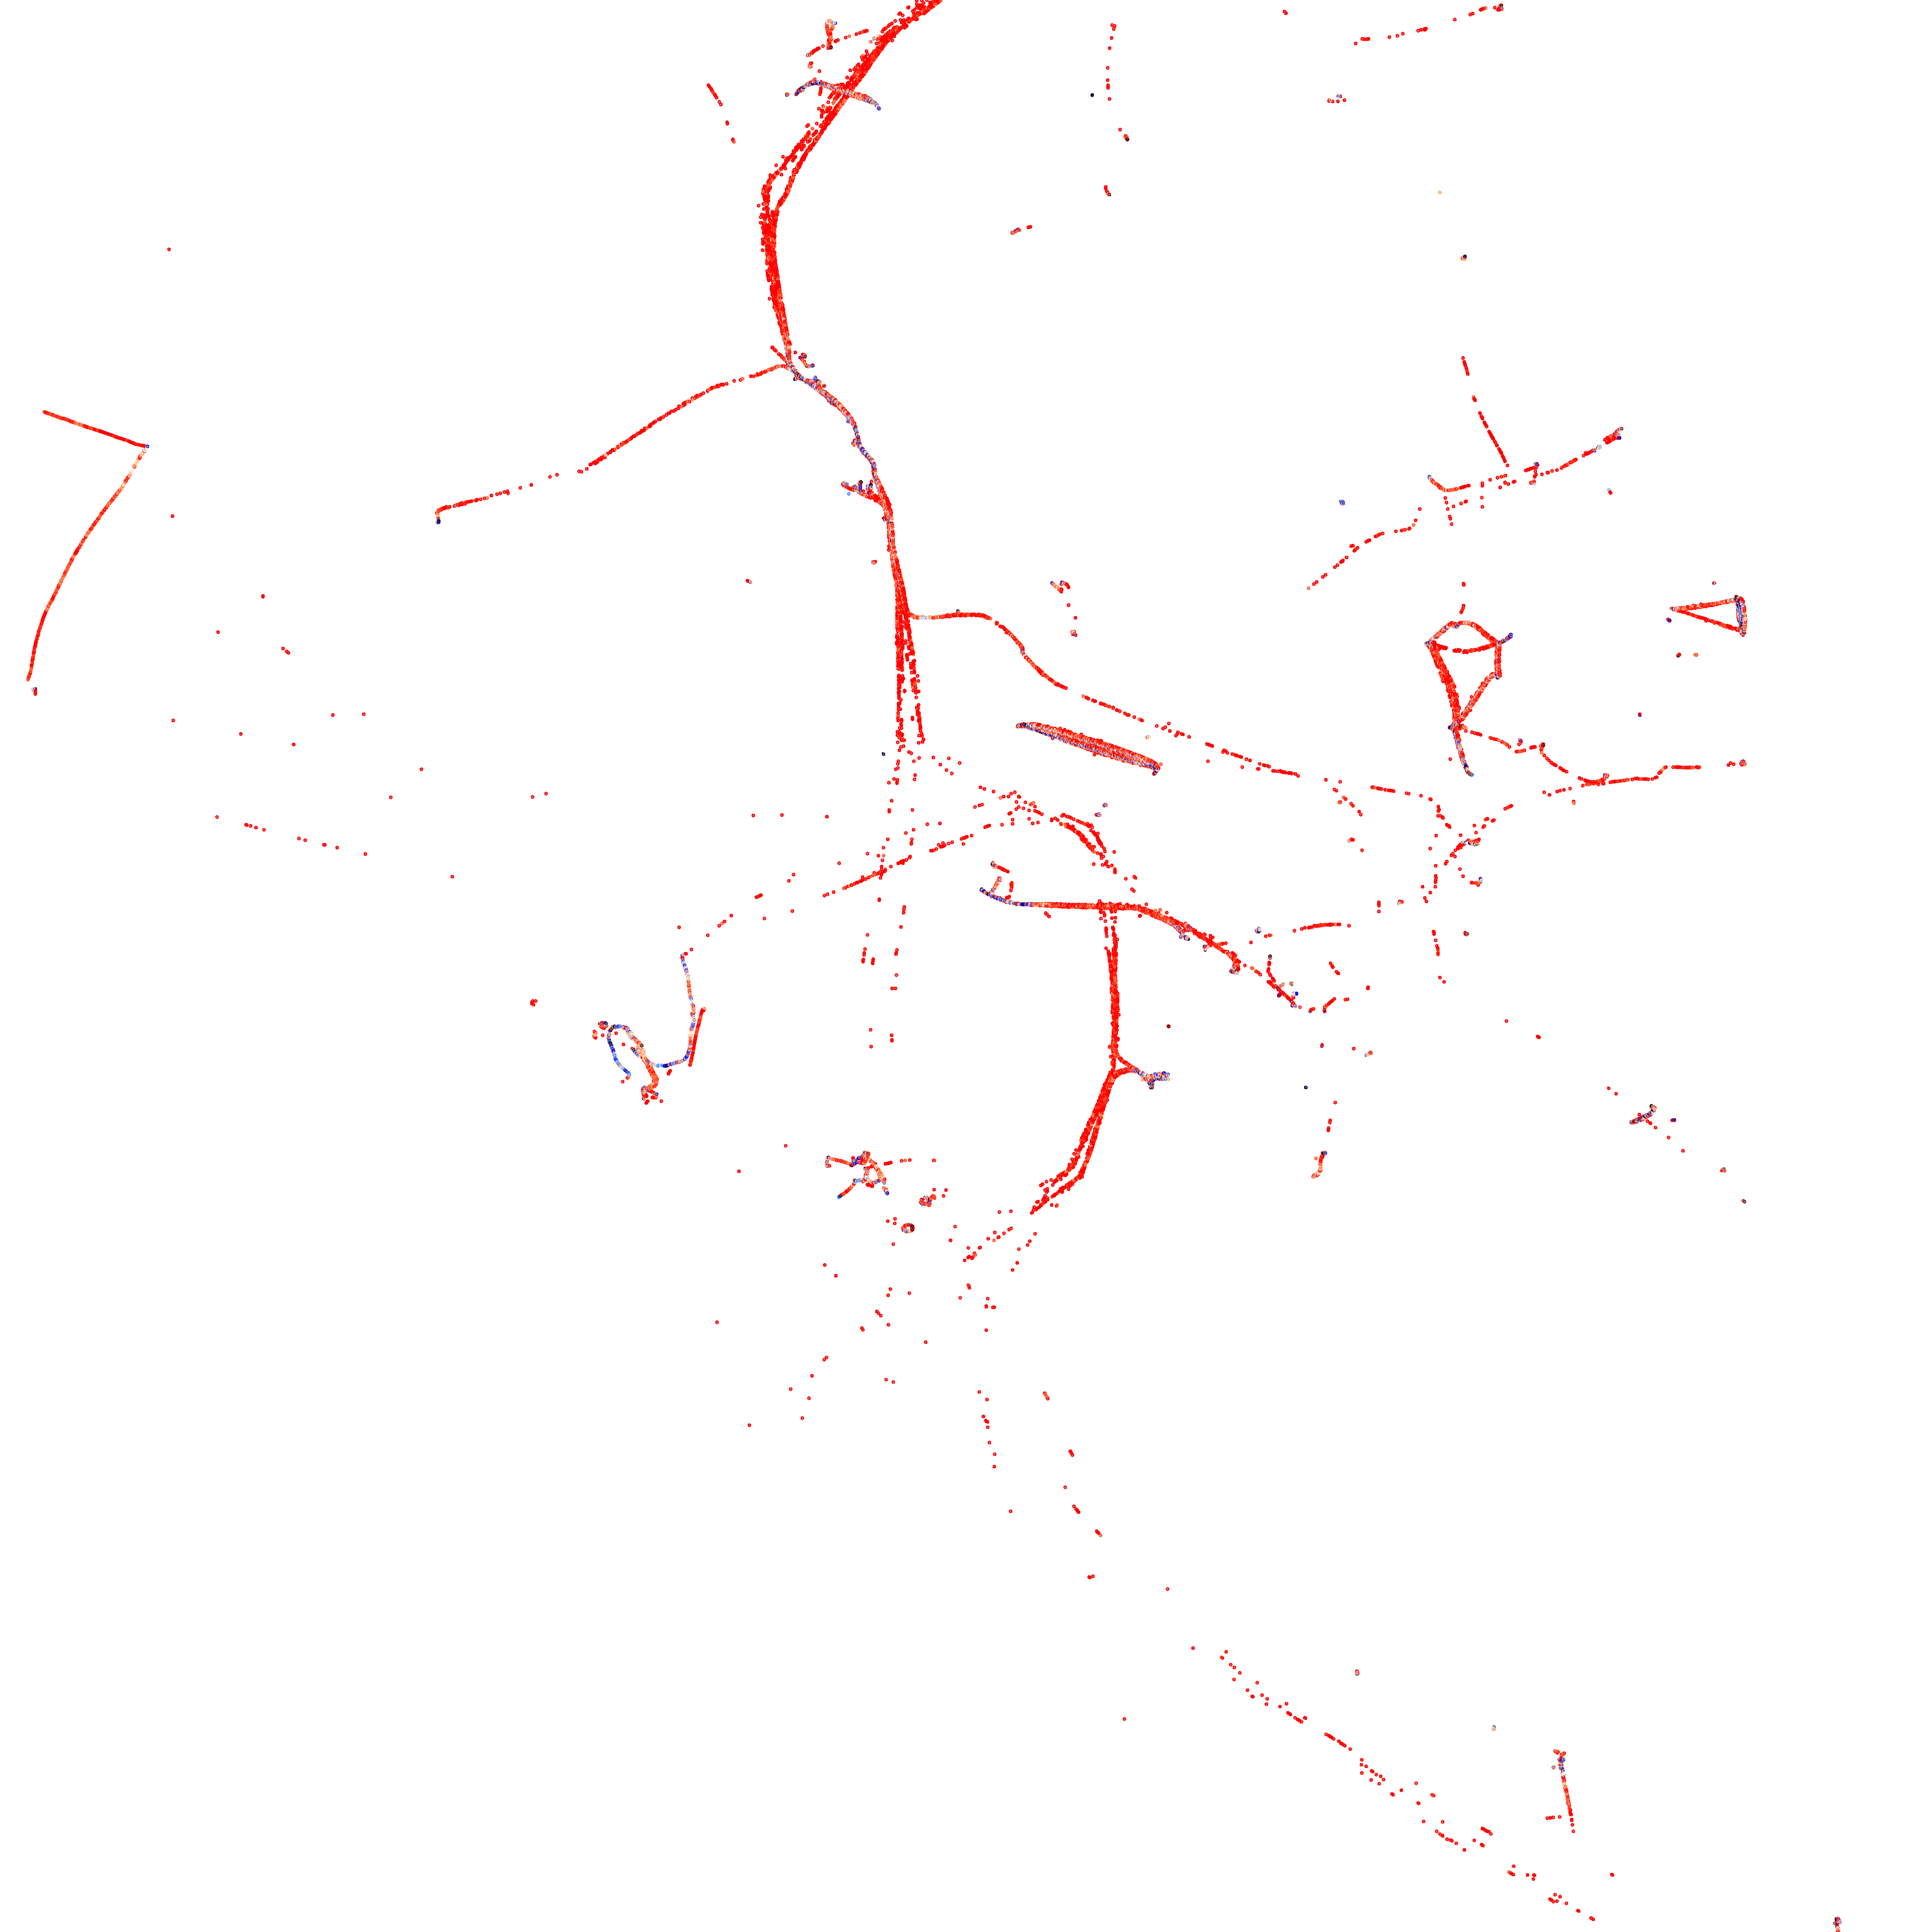

In [7]:
# plotting
detailed_plot = False
if detailed_plot:
    columns = ['geometry', 'mmsi']  # columns to be plotted
    # plot simplified trajectories
    map = network.trajectories.to_traj_gdf()[columns].explore(column='mmsi', name='Simplified trajectories', 
                                                              style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
                                                              legend=False)
    # plot significant turning points with their cluster ID
    map = network.significant_points[['clusterID', 'geometry']].explore(m=map, name='all waypoints with cluster ID', legend=False,
                                                                        marker_kwds={'radius':2},
                                                                        style_kwds={'opacity':0.2})
else:
    # plot basemap
    map = folium.Map(location=[59, 5], tiles="OpenStreetMap", zoom_start=8)
    # plot traffic as raster overlay
    map = visualize.traffic_raster_overlay(network.gdf, map)

# plot cluster centroids and their convex hull
cluster_centroids = network.waypoints
cluster_centroids.set_geometry('geometry', inplace=True)
map = cluster_centroids[['clusterID', 'geometry']].explore(m=map, name='cluster centroids', legend=False,
                                                           marker_kwds={'radius':3},
                                                           style_kwds={'color':'red', 'fillColor':'red', 'fillOpacity':1})
cluster_centroids.set_geometry('convex_hull', inplace=True)
map = cluster_centroids[['clusterID', 'convex_hull']].explore(m=map, name='cluster convex hulls', legend=False,
                                                              style_kwds={'color':'red', 'fillColor':'red', 'fillOpacity':0.2})
folium.LayerControl().add_to(map)

# add a title
title = f'HDBSCAN parameters: min_samples={min_samples}'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   

map.get_root().html.add_child(folium.Element(title_html))

map

In [8]:
network.significant_points

,date_time_utc,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,geometry,speed,clusterID
0,2022-04-01 06:30:21,209989000_0,9235505,90,4.62360,59.5881,10.0,167.2,174,0,1,POINT (4.62360 59.58810),4.473722,16
1,2022-04-01 07:23:40,209989000_0,9235505,90,4.66145,59.4478,10.0,168.1,175,0,1,POINT (4.66145 59.44780),4.507809,16
2,2022-04-01 08:47:21,209989000_0,9235505,90,4.71771,59.2073,10.5,155.7,149,0,3,POINT (4.71771 59.20730),5.397732,18
3,2022-04-01 09:04:00,209989000_0,9235505,90,4.76252,59.1618,11.0,149.0,145,0,1,POINT (4.76252 59.16180),6.287710,18
4,2022-04-01 10:52:00,209989000_0,9235505,90,5.07398,58.8951,10.0,152.7,150,0,1,POINT (5.07398 58.89510),5.728811,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,2022-04-02 23:57:31,563091400_2,9542984,143,5.50510,59.2374,0.2,284.0,126,1,3,POINT (5.50510 59.23740),0.122988,-1
7562,2022-04-01 00:31:40,565938000_1,9468580,76,5.72756,58.9845,0.0,141.8,208,5,3,POINT (5.72756 58.98450),0.070773,97
7563,2022-04-01 01:37:41,565938000_1,9468580,76,5.72772,58.9844,0.0,141.8,208,5,3,POINT (5.72772 58.98440),0.037298,97
7564,2022-04-01 05:58:35,565938000_11,9468580,76,5.72754,58.9845,0.0,141.8,208,5,3,POINT (5.72754 58.98450),0.046124,97
